#Classification de la base MNIST par réseau de neurones

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import time

En utilisant la classe
```
CLASS torchvision.datasets.MNIST
```
documentée ici :

https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST


In [ ]:
# Définition d'une transformation pour normaliser les niveaux de gris dans [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(), # Convertion des images en tenseurs
     transforms.Normalize((0.5,), (0.5,))]) # Normalisation des valeurs des pixels entre -1 et 1

batch_size = 16   # définir la taille de lot

# Chargement de l'ensemble de données MNIST pour l'entraînement
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

# Création d'un chargeur de données pour l'ensemble de données d'entraînement
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Chargement de l'ensemble de données MNIST pour les tests
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Création  d'un chargeur de données pour l'ensemble de données de test
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# Création d'une instance de l'ensemble de données MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 95407684.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4854943.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 35167456.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13895352.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Notre objectif général du code ci-dessus est de charger l'ensemble de données MNIST pour la classification d'images en utilisant des chargeurs de données pour l'entraînement et les tests.

Plus spécifiquement,
- On a commencer par la définition de la transformation transform qui nous permet de transformer et de normalise les niveaux de gris des images dans l'intervalle [-1, 1].
code explication : transforms.ToTensor veut dire quant on rencontre une image on veut qu'elle soit en format tensor et transforms.Normalize pour une normalisation parceque nos image sont de base entre 0 et 1 et nous on veux travailler avec des images qui sont entre -1 t 1 parceque nos fonctions d'activation sont centrées en 0 alors le mieux est que nos données soient aussi centrées en 0.Dans le tp4 vu en cours La moyenne et l'écart-type sont définis avec un triplet à (0.5, 0.5, 0.5) pour centrer les valeurs des canaux couleur autour de 0. Mais ici comme, on a des image en niveau de gris donc à la place des triplet une seul car on a un seul cannal.  Ensuite viens la définition de la taille de lot à utiliser lors du chargement des données dans le modèle.

- Après la définition de la transformation, nous sommes passé au chargement de l'ensemble de données MNIST pour l'entraînement et les tests en utilisant la classe torchvision.datasets.MNIST. Pour info le jeu de données MNIST normalement contient 70 000 images, avec 60 000 images pour l'entraînement et 10 000 images pour les tests.c'est la même idée comme vu au premier cours en utilisant les pourcentages ( 80% de données pour l'entrinement,10% pour le test et 10% pour la validation). En plus Chaque image a une taille de 28 x 28 pixels et est représentée sous forme de tenseur 2D avec des valeurs de pixel comprises entre 0 et 255.

- Les objets trainset et testset defini ci-déssus contiennent les images et les étiquettes de chaque ensemble de données, qui sont utilisés pour créer les chargeurs de données trainloader et testloader à l'aide de torch.utils.data.DataLoader. Les chargeurs de données sont configurés avec une taille de lot que nous allons nommer batch_size.

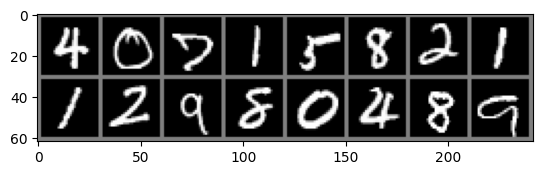

four  zero  seven one   five  eight two   one   one   two   nine  eight zero  four  eight nine 


In [ ]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Dans le code ci-déssus, nous avons défini une fonction imshow pour afficher une image normalisée. La fonction prend un tenseur d'image normalisé en entrée et le dénormalise en multipliant par 0,5 et en ajoutant 0,5. Ensuite, elle convertit le tenseur en un tableau NumPy et l'affiche avec matplotlib.pyplot.imshow.

Nous avons également utilisé la fonction iter pour obtenir un itérateur sur les lots du jeu de données d'entraînement, puis la méthode next pour obtenir le prochain lot d'images et d'étiquettes. Nous avons ensuite affiché les images avec leurs classes correspondantes en utilisant la fonction imshow et en imprimant les étiquettes de classe correspondantes avec print.

En exécutant ce code, on voit quelques images du jeu de données MNIST avec leurs classes correspondantes

Décrivons quantitativement la base de données MNIST;

- La taille de chaque image est de 28x28 pixels.

- Il y a 60000 images dans trainset et 10000 images dans testset.

- Il y a 6000 images par classe dans trainset et 1000 images par classe dans testset.

- Il y a 10 classes correspondant aux chiffres de 0 à 9.

In [ ]:
# Obtention d'une image à partir de l'ensemble de données
sample_image, _ = mnist_dataset[0]

# Obtention de la taille de l'image
image_size = sample_image.size
print("La taille de chaque image est : ", image_size )

# Nombre total d'images pour trainset et testset
trainset_im = len(trainset)
testset_im = len(testset)
print("Le nombre total d'images pour trainset est : ",trainset_im )
print("Le nombre total d'images pour testset est : ", testset_im)

# Nombre d'images par classe
im_per_class_trainset = [0]*10
im_per_class_testset = [0]*10

for image, label in trainloader:
    for l in label:
        im_per_class_trainset[l] += 1

for image, label in testloader:
    for l in label:
        im_per_class_testset[l] += 1

print("Le nombre d'images par classe pour trainset est : ", im_per_class_trainset)
print("Le nombre d'images par classe pour testset est : ", im_per_class_testset)

# Affichage du nombre de classes
print("Le nombre de classes est : ", len(set(trainset.classes)))

La taille de chaque image est :  (28, 28)
Le nombre total d'images pour trainset est :  60000
Le nombre total d'images pour testset est :  10000
Le nombre d'images par classe pour trainset est :  [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
Le nombre d'images par classe pour testset est :  [980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009]
Le nombre de classes est :  10


In [ ]:
import torchvision
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

In [ ]:
digits = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
for image, label in mnist_trainset:
    digits[label].append(image)
for image, label in mnist_testset:
    digits[label].append(image)


In [ ]:
for digit in digits:
    # Generate a random vector from a standard normal distribution.
    z = torch.randn(28, 28)
    # Calculate the mean and covariance matrix for this digit.
   mean = digits[digit]['mean']
    covariance = digits[digit]['covariance']
    # Apply the Cholesky decomposition to the covariance matrix.
    L = torch.linalg.cholesky(covariance)
    # Use the Cholesky decomposition to transform the random vector.
    x = torch.matmul(L, z)
    # Add the mean to the transformed random vector.
    x = x + mean
    # Reshape the vector into an image.
    x = x.view(1, 28, 28)
    # Save the image.
    torchvision.utils.save_image(x, f'{digit}.png')


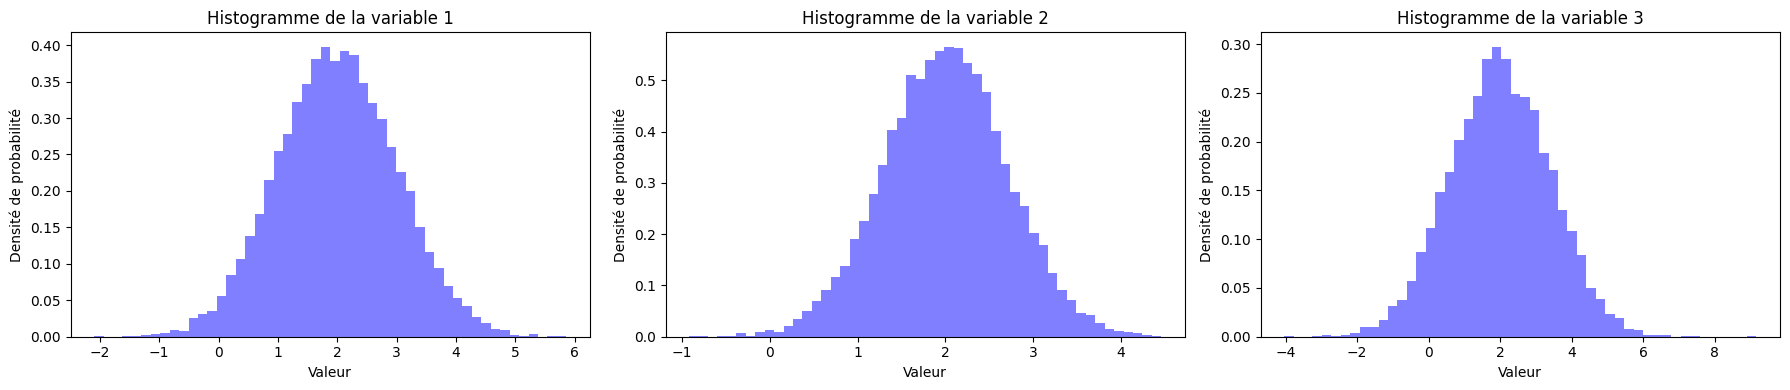

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def echantillonnage_gauss_diagonal(mu, precision, taille):
    n = len(mu)
    x = np.zeros((n, taille))
    for i in range(n):
        x[i] = echantillonner_gaussien(mu[i], 1 / np.sqrt(precision[i]), taille)  # Échantillonnage gaussien univarié
    return x

def echantillonner_gaussien(mu, sigma, taille):
    return np.random.normal(mu, sigma, taille)

# Paramètres de la distribution
mu = [2, 2, 2]  # Vecteur des moyennes
precision = [1, 2, 0.5]  # Vecteur de la précision (inverse de la variance)
taille_echantillon = 10000  # Taille de l'échantillon

# Générer un échantillon gaussien multivarié
echantillon = echantillonnage_gauss_diagonal(mu, precision, taille_echantillon)

# Tracer les histogrammes
fig, axs = plt.subplots(1, len(mu), figsize=(6*len(mu), 4))
for i in range(len(mu)):
    axs[i].hist(echantillon[i], bins=50, density=True, alpha=0.5, color='blue')
    axs[i].set_xlabel('Valeur')
    axs[i].set_ylabel('Densité de probabilité')
    axs[i].set_title(f'Histogramme de la variable {i+1}')
plt.tight_layout()
plt.show()

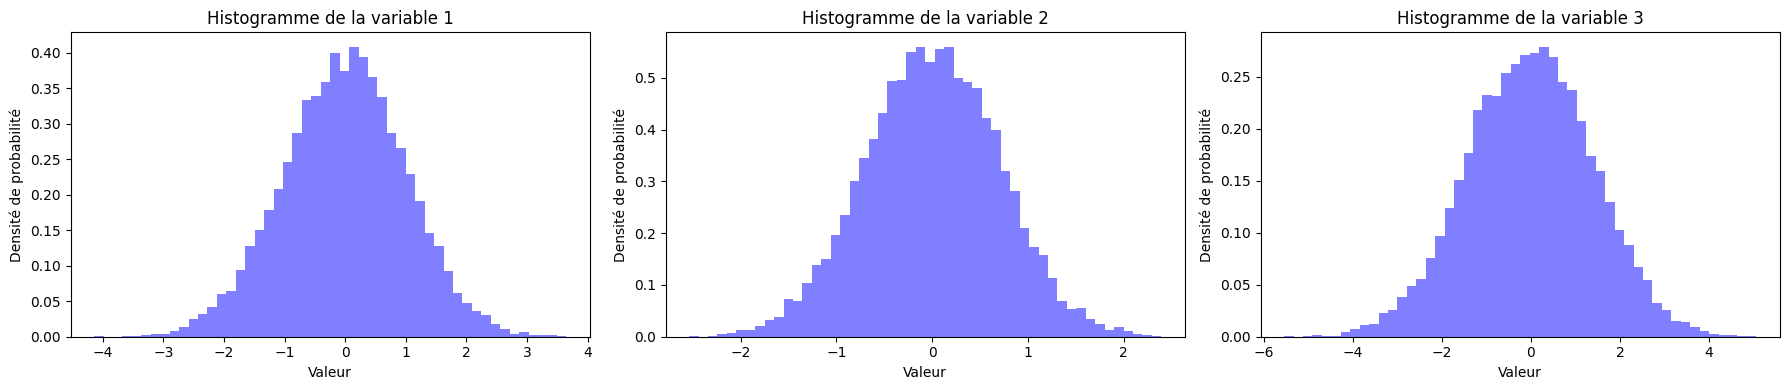

In [4]:
# Paramètres de la distribution
mu = [0, 0, 0]  # Vecteur des moyennes
precision = [1, 2, 0.5]  # Vecteur de la précision (inverse de la variance)
taille_echantillon = 10000  # Taille de l'échantillon

# Générer un échantillon gaussien multivarié
echantillon = echantillonnage_gauss_diagonal(mu, precision, taille_echantillon)

# Tracer les histogrammes sur une ligne
fig, axs = plt.subplots(1, len(mu), figsize=(6*len(mu), 4))
for i in range(len(mu)):
    axs[i].hist(echantillon[i], bins=50, density=True, alpha=0.5, color='blue')
    axs[i].set_xlabel('Valeur')
    axs[i].set_ylabel('Densité de probabilité')
    axs[i].set_title(f'Histogramme de la variable {i+1}')
plt.tight_layout()
plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5472051.46it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160153.17it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1518608.72it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4018251.16it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



<function matplotlib.pyplot.show(close=None, block=None)>

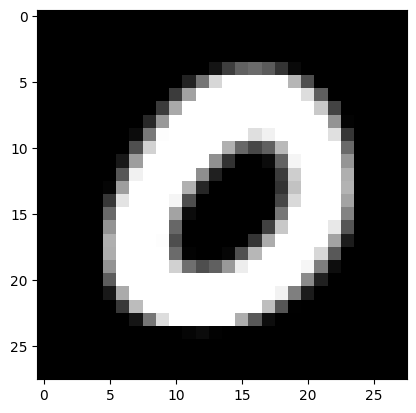

In [5]:
from numpy.ma.core import reshape
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliser les valeurs des pixels
])

# Charger le jeu de données MNIST
train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)

# Filtrer les images de la première classe (classe 0)
class_0_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 0]
class_0_images = torch.stack([train_dataset[i][0] for i in class_0_indices])

# Redimensionner les images en vecteurs
class_0_vectors = class_0_images.view(class_0_images.size(0), -1)

# On calcule la matrice de variance-covariance en utilisant torch.matmul() pour effectuer la multiplication
# matricielle et en divisant par la taille du vecteur pour obtenir une estimation non biaisée.
cov_matrix = torch.matmul(class_0_vectors.T, class_0_vectors) / class_0_vectors.size(0)

# On calcule le vecteur moyen en utilisant torch.mean() avec dim=0 pour calculer
# la moyenne le long de la première dimension (les exemples).
mean_vector = torch.mean(class_0_vectors, dim=0)
U, S, Vh = np.linalg.svd(cov_matrix, full_matrices = True, hermitian=True)
#print(S)
X = np.random.normal(size=784)
Y = mean_vector + U @ np.diag(np.sqrt(S)) @ X
Z = Y.reshape((28,28))
plt.imshow(mean_vector.reshape((28,28)),vmin=0,vmax=1,cmap='gray')
#plt.imshow(Z,vmin=0,vmax=1,cmap='gray')
plt.show

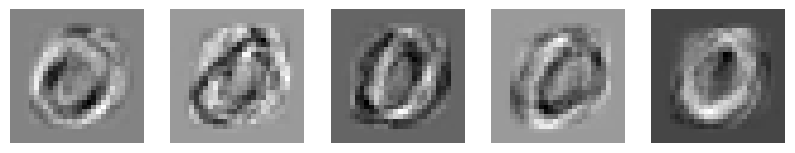

In [ ]:
from numpy.ma.core import reshape
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliser les valeurs des pixels
])

# Charger le jeu de données MNIST
train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)

# Filtrer les images de la première classe (classe 0)
class_0_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 0]
class_0_images = torch.stack([train_dataset[i][0] for i in class_0_indices])

# Redimensionner les images en vecteurs
class_0_vectors = class_0_images.view(class_0_images.size(0), -1)

# On calcule la matrice de variance-covariance en utilisant torch.matmul() pour effectuer la multiplication
# matricielle et en divisant par la taille du vecteur pour obtenir une estimation non biaisée.
cov_matrix = torch.matmul(class_0_vectors.T, class_0_vectors) / class_0_vectors.size(0)

# On calcule le vecteur moyen en utilisant torch.mean() avec dim=0 pour calculer
# la moyenne le long de la première dimension (les exemples).
mean_vector = torch.mean(class_0_vectors, dim=0)
U, S, Vh = np.linalg.svd(cov_matrix, full_matrices=True, hermitian=True)

# Nombre de simulations à effectuer
num_simulations = 5

# Créer une figure pour afficher les images générées
fig, axes = plt.subplots(1, num_simulations, figsize=(num_simulations * 2, 2))

# Boucle pour générer et afficher les images
for i in range(num_simulations):
    # Générer un échantillon aléatoire
    X = np.random.normal(size=784)

    # Générer une nouvelle image
    Y = mean_vector + U @ np.diag(np.sqrt(S)) @ X
    Z = Y.reshape((28, 28))

    # Afficher l'image générée
    axes[i].imshow(Z, cmap='gray')
    axes[i].axis('off')

# Afficher la figure contenant les images générées
plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 87600475.43it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 82912863.67it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21617024.44it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11958900.67it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



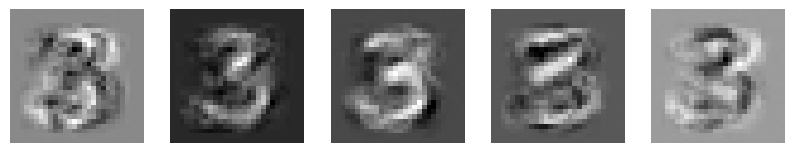

In [ ]:
from numpy.ma.core import reshape
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliser les valeurs des pixels
])

# Charger le jeu de données MNIST
train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)

# Filtrer les images de la troisième classe (classe 3)
class_3_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 3]
class_3_images = torch.stack([train_dataset[i][0] for i in class_3_indices])

# Redimensionner les images en vecteurs
class_3_vectors = class_3_images.view(class_3_images.size(0), -1)

# On calcule la matrice de variance-covariance en utilisant torch.matmul() pour effectuer la multiplication
# matricielle et en divisant par la taille du vecteur pour obtenir une estimation non biaisée.
cov_matrix = torch.matmul(class_3_vectors.T, class_3_vectors) / class_3_vectors.size(0)

# On calcule le vecteur moyen en utilisant torch.mean() avec dim=0 pour calculer
# la moyenne le long de la première dimension (les exemples).
mean_vector = torch.mean(class_3_vectors, dim=0)
U, S, Vh = torch.svd(cov_matrix)

# Nombre de simulations à effectuer
num_simulations = 5

# Créer une figure pour afficher les images générées
fig, axes = plt.subplots(1, num_simulations, figsize=(num_simulations * 2, 2))

# Boucle pour générer et afficher les images
for i in range(num_simulations):
    # Générer un échantillon aléatoire
    X = np.random.normal(size=784)

    # Générer une nouvelle image
    Y = mean_vector + U @ torch.diag(torch.sqrt(S)) @ X
    Z = Y.reshape((28, 28))

    # Afficher l'image générée
    axes[i].imshow(Z, cmap='gray')
    axes[i].axis('off')

# Afficher la figure contenant les images générées
plt.show()

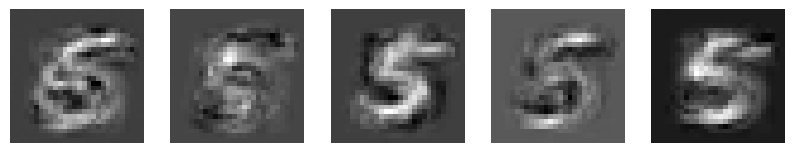

In [ ]:
from numpy.ma.core import reshape
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliser les valeurs des pixels
])

# Charger le jeu de données MNIST
train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)

# Filtrer les images de la cinquième classe (classe 5)
class_5_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 5]
class_5_images = torch.stack([train_dataset[i][0] for i in class_5_indices])

# Redimensionner les images en vecteurs
class_5_vectors = class_5_images.view(class_5_images.size(0), -1)

# On calcule la matrice de variance-covariance en utilisant torch.matmul() pour effectuer la multiplication
# matricielle et en divisant par la taille du vecteur pour obtenir une estimation non biaisée.
cov_matrix = torch.matmul(class_5_vectors.T, class_5_vectors) / class_5_vectors.size(0)

# On calcule le vecteur moyen en utilisant torch.mean() avec dim=0 pour calculer
# la moyenne le long de la première dimension (les exemples).
mean_vector = torch.mean(class_5_vectors, dim=0)
U, S, Vh = torch.svd(cov_matrix)

# Nombre de simulations à effectuer
num_simulations = 5

# Créer une figure pour afficher les images générées
fig, axes = plt.subplots(1, num_simulations, figsize=(num_simulations * 2, 2))

# Boucle pour générer et afficher les images
for i in range(num_simulations):
    # Générer un échantillon aléatoire
    X = np.random.normal(size=784)

    # Générer une nouvelle image
    Y = mean_vector + U @ torch.diag(torch.sqrt(S)) @ X
    Z = Y.reshape((28, 28))

    # Afficher l'image générée
    axes[i].imshow(Z, cmap='gray')
    axes[i].axis('off')

# Afficher la figure contenant les images générées
plt.show()

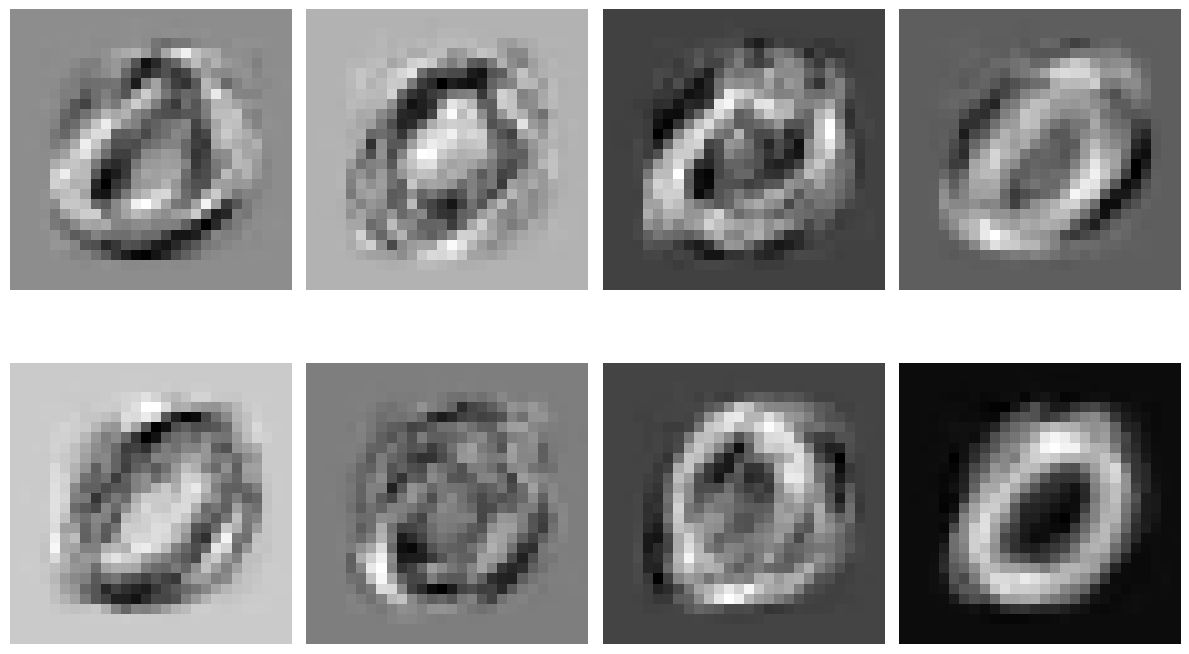

In [ ]:
from numpy.ma.core import reshape
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Transformation des données
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir l'image en tenseur
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliser les valeurs des pixels
])

# Charger le jeu de données MNIST
train_dataset = datasets.MNIST('data/', train=True, download=True, transform=transform)

# Filtrer les images de la première classe (classe 0)
class_0_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == 0]
class_0_images = torch.stack([train_dataset[i][0] for i in class_0_indices])

# Redimensionner les images en vecteurs
class_0_vectors = class_0_images.view(class_0_images.size(0), -1)

# On calcule la matrice de variance-covariance en utilisant torch.matmul() pour effectuer la multiplication
# matricielle et en divisant par la taille du vecteur pour obtenir une estimation non biaisée.
cov_matrix = torch.matmul(class_0_vectors.T, class_0_vectors) / class_0_vectors.size(0)

# On calcule le vecteur moyen en utilisant torch.mean() avec dim=0 pour calculer
# la moyenne le long de la première dimension (les exemples).
mean_vector = torch.mean(class_0_vectors, dim=0)
U, S, Vh = np.linalg.svd(cov_matrix, full_matrices=True, hermitian=True)

# Nombre de simulations à effectuer
num_simulations = 8
simulations_per_row = 4

# Créer une figure pour afficher les images générées
fig, axes = plt.subplots(num_simulations // simulations_per_row, simulations_per_row, figsize=(12, 8))

# Boucle pour générer et afficher les images
for i in range(num_simulations):
    # Générer un échantillon aléatoire
    X = np.random.normal(size=784)

    # Générer une nouvelle image
    Y = mean_vector + U @ np.diag(np.sqrt(S)) @ X
    Z = Y.reshape((28, 28))

    # Calculer les indices de sous-figures
    row_index = i // simulations_per_row
    col_index = i % simulations_per_row

    # Afficher l'image générée
    axes[row_index, col_index].imshow(Z, cmap='gray')
    axes[row_index, col_index].axis('off')

# S'assurer que les sous-figures non utilisées sont masquées
for i in range(num_simulations, axes.size):
    row_index = i // simulations_per_row
    col_index = i % simulations_per_row
    axes[row_index, col_index].axis('off')

# Afficher la figure contenant les images générées
plt.tight_layout()
plt.show()